In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
sns.set_context("paper")
EVAL_DATA = Path().absolute().parents[0] / "eval_data"
list(EVAL_DATA.iterdir())

[PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/egnnr12_eval_data.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/relegnn_eval_data.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/pocket_clusters_with_klifs.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/eval_data.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/egnnr_eval_data.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/pocket_klifs_metadata.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/README.md'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/dti_less_features_eval_data.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/train_runs.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/transformer_eval_data.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-

## Load eval data

In [4]:
eval_data = pd.read_csv(EVAL_DATA / "eval_data.csv")
eval_data.head()

,pred,ident,model,split,split_seed,activities.standard_value,target
0,5.668407,44685,GIN,scaffold,4,6.000000,6.000000
1,5.251923,44685,GIN,pocket,4,6.000000,6.000000
2,6.395972,44685,EGNN,scaffold,4,6.000000,6.000000
3,5.828227,44685,EGNN,pocket,4,6.000000,6.000000
4,4.179743,105738,GIN,scaffold,4,8.376751,8.376751


In [5]:
dti_eval_data = pd.read_csv(EVAL_DATA / "dti_eval_data.csv")
dti_eval_data.head()

,pred,ident,model,split,split_seed,activities.standard_value,target
0,7.199682,198998,DTI,scaffold,0,5.853872,5.853872
1,7.647483,198998,DTI,scaffold,1,5.853872,5.853872
2,6.981037,198998,DTI,random,2,5.853872,5.853872
3,7.434746,198998,DTI,pocket,3,5.853872,5.853872
4,6.067016,198998,DTI,random,3,5.853872,5.853872


In [6]:
st_eval_data = pd.read_csv(EVAL_DATA / "transformer_eval_data.csv")
st_eval_data.head()

,pred,ident,model,split,split_seed,activities.standard_value,target
0,7.139952,44685,Transformer,scaffold,4,6.000000,6.000000
1,6.066615,44685,Transformer,pocket,4,6.000000,6.000000
2,8.714574,105738,Transformer,scaffold,4,8.376751,8.376751
3,6.577642,105738,Transformer,pocket,4,8.376751,8.376751
4,6.789509,108868,Transformer,scaffold,4,6.070581,6.070581


In [7]:
eval_data = pd.concat((eval_data, dti_eval_data, st_eval_data), axis=0).reset_index()
eval_data.groupby("model").size()

model
DTI            51556
EGNN           59467
GIN            55839
Transformer    44958
dtype: int64

### Calculate absolute prediction errors
(and filter some weird outliers)

In [8]:
eval_data["error"] = (eval_data["pred"] - eval_data["target"]).abs()

In [9]:
eval_data[eval_data["error"] > 5].groupby("model").size() # ????

model
DTI            20
EGNN            6
GIN            56
Transformer    12
dtype: int64

In [10]:
eval_data = eval_data[eval_data["error"] < 100]

In [11]:
# sanity check that we use the same targets for all models
assert (eval_data.groupby("ident")["target"].std() == 0).all()

### Define model full names, useful for plotting

In [12]:
full_names = {
    "Transformer": "Transformer",
    "EGNN (R)": "Complex-EGNN (R)",
    "EGNN (R/12)": "Complex-EGNN (R/12)",
    "EGNN": "Complex-EGNN",
    "GIN": "Ligand-GNN",
    "DTI": "KiSSim DeepDTA"
}
eval_data["model_full_name"] = eval_data["model"].apply(full_names.get)
eval_data.head()

,index,pred,ident,model,split,split_seed,activities.standard_value,target,error,model_full_name
0,0,5.668407,44685,GIN,scaffold,4,6.000000,6.000000,0.331593,Ligand-GNN
1,1,5.251923,44685,GIN,pocket,4,6.000000,6.000000,0.748077,Ligand-GNN
2,2,6.395972,44685,EGNN,scaffold,4,6.000000,6.000000,0.395972,Complex-EGNN
3,3,5.828227,44685,EGNN,pocket,4,6.000000,6.000000,0.171773,Complex-EGNN
4,4,4.179743,105738,GIN,scaffold,4,8.376751,8.376751,4.197008,Ligand-GNN


### Calculate test metrics
* Correlation of test prediction and target
* Mean absolute error

In [13]:
corr_data = eval_data.groupby(["split", "model_full_name", "split_seed"])[["pred", "target"]].corr("spearman").iloc[0::2, -1]
corr_data = corr_data.unstack().reset_index().rename(columns={"pred": "test_corr"})
corr_data.head()

,split,model_full_name,split_seed,test_corr
0,pocket,Complex-EGNN,0,0.372135
1,pocket,Complex-EGNN,1,0.348112
2,pocket,Complex-EGNN,2,0.327922
3,pocket,Complex-EGNN,3,0.188877
4,pocket,Complex-EGNN,4,0.272919


In [15]:
mae_data = eval_data.groupby(["split", "model_full_name", "split_seed"])["error"].mean().reset_index()
mae_data.head()

,split,model_full_name,split_seed,error
0,pocket,Complex-EGNN,0,0.849410
1,pocket,Complex-EGNN,1,0.940820
2,pocket,Complex-EGNN,2,0.798744
3,pocket,Complex-EGNN,3,0.895928
4,pocket,Complex-EGNN,4,0.950526


(0.0, 2.0)

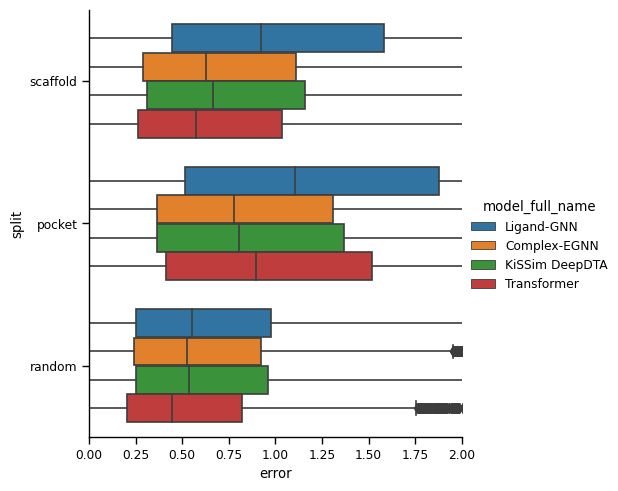

In [16]:
sns.catplot(eval_data, x="error", y="split", hue="model_full_name", kind="box")
plt.xlim(left=0, right=2)

In [17]:
corr_data.groupby(["split", "model_full_name"])["test_corr"].agg(["mean", "std"])

mean       std
split    model_full_name                    
pocket   Complex-EGNN     0.301993  0.073075
         KiSSim DeepDTA   0.286697  0.080830
         Ligand-GNN       0.121021  0.084891
         Transformer      0.247237  0.094810
random   Complex-EGNN     0.690979  0.006018
         KiSSim DeepDTA   0.667764  0.008368
         Ligand-GNN       0.661203  0.009375
         Transformer      0.749448  0.008413
scaffold Complex-EGNN     0.552584  0.046307
         KiSSim DeepDTA   0.515484  0.056723
         Ligand-GNN       0.305311  0.029918
         Transformer      0.620472  0.042137

IndexError: index 0 is out of bounds for axis 0 with size 0

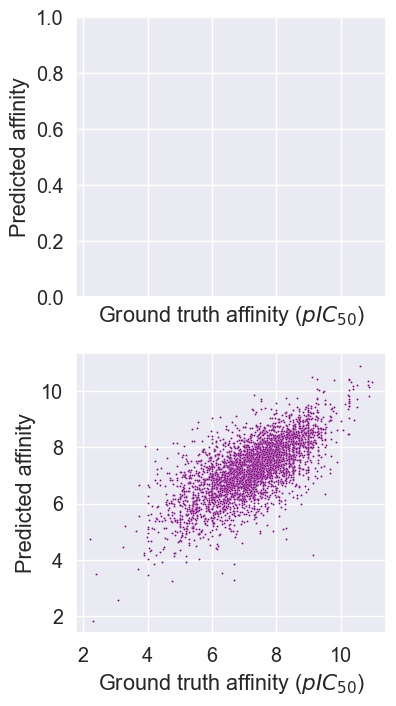

In [18]:
split, seed = "random", 4
split_query = f"split == '{split}' and split_seed == {seed}"
sns.set(font_scale=1.3)


scaf_1 = eval_data.query(split_query)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8), sharex=True, sharey=False)
sns.scatterplot(scaf_1.query("model == 'EGNN (R/12)'"), x="target", y="pred", color="green", ax=ax1, s=2)
sns.scatterplot(scaf_1.query("model == 'DTI'"), x="target", y="pred", color="purple", ax=ax2, s=2)
for ax in (ax1, ax2):
    ax.set_ylabel("Predicted affinity")
    ax.set_xlabel("Ground truth affinity (${pIC}_{50}$)")

rho1 = corr_data.query(split_query).query("model_full_name == 'Complex-EGNN (R/12)'").test_corr.values[0]
rho2 = corr_data.query(split_query).query("model_full_name == 'KiSSim DeepDTA'").test_corr.values[0]
ax1.set_title(f"Complex-EGNN $\\rho={rho1:.2f}$") 
ax2.set_title(f"KiSSim DTI $\\rho={rho2:.2f}$") 
f.suptitle(f"{split} split (seed={seed})")
f.tight_layout()

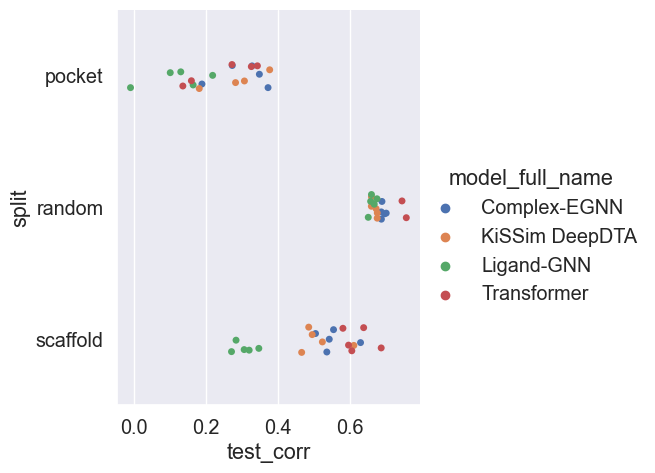

In [19]:
mask = corr_data["model_full_name"] != "Ligand-GNN"
sns.catplot(corr_data, x="test_corr", y="split", kind="strip", hue="model_full_name")

### Model improvement plot
Let $r_1$ and $r_2$ be the correlation of prediction and target of two models. We define the relative improvement of model $1$ over $2$ as
$$
\delta_{1,2} = \frac{r_1}{r_2} - 1 \in (-\infty, \infty)
$$

In [22]:
corr_data.query("model_full_name == 'KiSSim DeepDTA'")

,split,model_full_name,split_seed,test_corr
5,pocket,KiSSim DeepDTA,1,0.282045
6,pocket,KiSSim DeepDTA,2,0.376683
7,pocket,KiSSim DeepDTA,3,0.181419
8,pocket,KiSSim DeepDTA,4,0.306642
24,random,KiSSim DeepDTA,0,0.658866
25,random,KiSSim DeepDTA,1,0.658545
26,random,KiSSim DeepDTA,2,0.671717
27,random,KiSSim DeepDTA,3,0.674701
28,random,KiSSim DeepDTA,4,0.674990
41,scaffold,KiSSim DeepDTA,0,0.522731


(('pocket', 1),    model_full_name  test_corr
1     Complex-EGNN   0.348112
5   KiSSim DeepDTA   0.282045
10      Ligand-GNN   0.164493
15     Transformer   0.342626)
(('pocket', 2),    model_full_name  test_corr
2     Complex-EGNN   0.327922
6   KiSSim DeepDTA   0.376683
11      Ligand-GNN   0.101025
16     Transformer   0.325793)
(('pocket', 3),    model_full_name  test_corr
3     Complex-EGNN   0.188877
7   KiSSim DeepDTA   0.181419
12      Ligand-GNN  -0.009149
17     Transformer   0.272195)
(('pocket', 4),    model_full_name  test_corr
4     Complex-EGNN   0.272919
8   KiSSim DeepDTA   0.306642
13      Ligand-GNN   0.130210
18     Transformer   0.135932)
(('random', 0),    model_full_name  test_corr
19    Complex-EGNN   0.699686
24  KiSSim DeepDTA   0.658866
29      Ligand-GNN   0.656540
34     Transformer   0.743499)
(('random', 2),    model_full_name  test_corr
21    Complex-EGNN   0.686121
26  KiSSim DeepDTA   0.671717
31      Ligand-GNN   0.666515
35     Transformer   0.755397

/Users/joschka/mambaforge/envs/kinodata/lib/python3.10/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


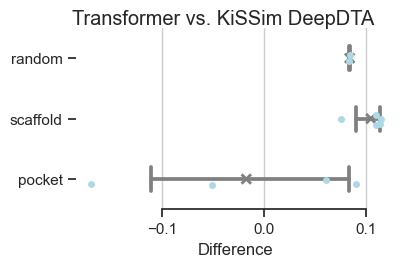

In [29]:
model_1, model_2 = "Transformer", "KiSSim DeepDTA"
index_1, index_2 = 3, 1
mode = "diff"

mask1 = (corr_data["split"] != "random") | (corr_data["split_seed"].isin([0,2]))
mask2 = ~((corr_data["split"] == "pocket") & (corr_data["split_seed"] == 0))
grouped = corr_data[mask1 & mask2].groupby(["split", "split_seed"])[["model_full_name", "test_corr"]]


for x in grouped:
    print(x)
if mode == "ratio":
    corr_diff = grouped.apply(lambda x: x.test_corr.values[index_1] / x.test_corr.values[index_2])
    corr_diff = corr_diff.reset_index().rename(columns={0: "corr_ratio"})
    corr_diff["improvement"] = (corr_diff["corr_ratio"] - 1) * 100
elif mode == "diff":
    corr_diff = grouped.apply(lambda x: x.test_corr.values[index_1] - x.test_corr.values[index_2])
    corr_diff = corr_diff.reset_index().rename(columns={0: "corr_diff"})
    corr_diff["improvement"] = corr_diff["corr_diff"]
    

f, ax = plt.subplots(figsize=(4, 2.5))
f.tight_layout()
f.suptitle(f"{model_1} vs. {model_2}")
sns.set_theme(style="ticks")
sns.stripplot(corr_diff, x="improvement", y="split", size=5, linewidth=0, color="lightblue", order=["random", "scaffold", "pocket"])
sns.pointplot(corr_diff, x="improvement", y="split", order=["random", "scaffold", "pocket"], join=False, color=".5", capsize=.4, markers="x")
ax.xaxis.grid(True)
ax.set(ylabel="")
if mode == "ratio":
    ax.set_xlabel(r"Improvement % (explained variance)")
elif mode == "diff":
    ax.set_xlabel("Difference")
sns.despine(trim=True, left=True)
# ax.set_xlim(left=0, right=2.0)
f.savefig("corr_diff_kinodata.pdf")

In [31]:
eval_data["abs_error"] = (eval_data["pred"] - eval_data["activities.standard_value"]).abs()

In [32]:
mae = (
    eval_data.groupby(["split", "split_seed", "model"])["abs_error"]
    .mean()
    .to_frame()
    .reset_index()
    .rename(columns={"abs_error": "mae"})
)
print(mae.groupby(["model", "split"])["mae"].agg(["mean", "std"]))

                          mean       std
model       split                       
DTI         pocket    0.923207  0.081473
            random    0.681560  0.008739
            scaffold  0.811859  0.030459
EGNN        pocket    0.887086  0.063667
            random    0.658575  0.013575
            scaffold  0.779452  0.021651
GIN         pocket    1.257423  0.181086
            random    0.687846  0.009813
            scaffold  1.097443  0.096543
Transformer pocket    1.006005  0.120430
            random    0.586301  0.010535
            scaffold  0.726594  0.026359


In [21]:
import biotite.sequence.align as align
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from kinodata.data.utils. similarity import _normalize_score_matrix

/Users/joschka/mambaforge/envs/kinodata/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
blosum = align.SubstitutionMatrix.std_protein_matrix()
score_matrix = blosum.score_matrix()
alph = blosum.get_alphabet1()
score_matrix = _normalize_score_matrix(score_matrix)
score_matrix

array([[1.        , 0.39223227, 0.2236068 , 0.35355339, 0.2236068 ,
        0.4472136 , 0.20412415, 0.375     , 0.35355339, 0.375     ,
        0.35355339, 0.2236068 , 0.31980107, 0.35355339, 0.35355339,
        0.625     , 0.47140452, 0.5       , 0.09128709, 0.21320072,
        0.25      , 0.375     , 0.81649658, 0.        ],
       [0.39223227, 1.        , 0.0877058 , 0.        , 0.1754116 ,
        0.0877058 , 0.08006408, 0.2941742 , 0.09245003, 0.2941742 ,
        0.2773501 , 0.0877058 , 0.0836242 , 0.09245003, 0.09245003,
        0.2941742 , 0.2773501 , 0.2941742 , 0.14322297, 0.1672484 ,
        0.09805807, 0.09805807, 0.32025631, 0.        ],
       [0.2236068 , 0.0877058 , 1.        , 0.63245553, 0.1       ,
        0.3       , 0.27386128, 0.1118034 , 0.31622777, 0.        ,
        0.10540926, 0.5       , 0.28603878, 0.42163702, 0.21081851,
        0.4472136 , 0.31622777, 0.1118034 , 0.        , 0.09534626,
        0.89442719, 0.55901699, 0.54772256, 0.        ],
       [0.353

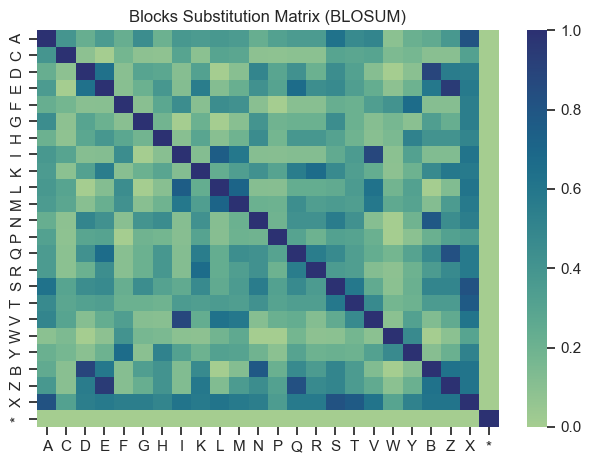

In [23]:
# sns.set_context("talk")
hm = sns.heatmap(score_matrix, xticklabels=alph, yticklabels=alph, cmap="crest", fmt="g")
hm.set_title("Blocks Substitution Matrix (BLOSUM)")
plt.tight_layout()

In [24]:
EGFR = "KVLGSGAFGTVYKVAIKVLEILDEAYVMAGVGPYVSRLLGIQLVTQLMPYGCLLDHVREYLEDVRLVHRDLAARNVLVITDFGLA"
KDR = "KPLGRGAFGQVIEVAVKMLALMSELKILIHIGLNVVNLLGAMVIVEFCKFGNLSTYLRSFLASRKCIHRDLAARNILLICDFGLA"

In [25]:
iEGFR = alph.encode_multiple(EGFR)
iKDR = alph.encode_multiple(KDR)

In [26]:
data = pd.DataFrame({
    "Residue sim.": score_matrix[iEGFR, iKDR]
}, index=[f"{a}{b}" for a,b in zip(EGFR, KDR)])

In [27]:
sample = data.iloc[:9]
dummy = pd.DataFrame({
    "Residue sim.": 0
}, index=["${\\dots}$"])
sample = pd.concat((sample, dummy))
sample

,Residue sim.
KK,1.000000
VP,0.213201
LL,1.000000
GG,1.000000
SR,0.353553
GG,1.000000
AA,1.000000
FF,1.000000
GG,1.000000
${\dots}$,0.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'KK'),
  Text(0, 1.5, 'VP'),
  Text(0, 2.5, 'LL'),
  Text(0, 3.5, 'GG'),
  Text(0, 4.5, 'SR'),
  Text(0, 5.5, 'GG'),
  Text(0, 6.5, 'AA'),
  Text(0, 7.5, 'FF'),
  Text(0, 8.5, 'GG'),
  Text(0, 9.5, '${\\dots}$')])

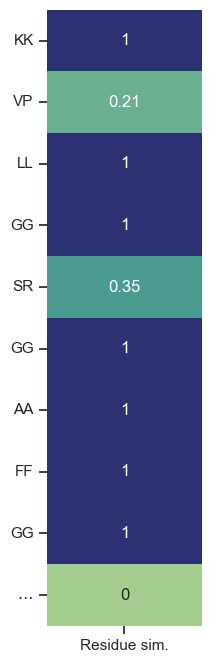

In [28]:
f, ax = plt.subplots(figsize=(2, 8))
sns.heatmap(sample, cmap="crest", vmin=score_matrix.min(), vmax=score_matrix.max(), annot=True, cbar=False)
plt.yticks(rotation=0)